In [1]:
# execfile ("D:/measuring/analysis/scripts/setup_analysis.py")

import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
from analysis.lib.sim import electron_nuclear_sim as nsc; reload(nsc)

from scipy.fftpack import fft, ifft, fftshift

In [ ]:
# Compare to envelope at zero DC. Very close, although slightly different at bigger detunings.

reload(nsc)
NVsys = nsc.noisy_NV_system(mw_duration=125e-9,carbon_params = [],inc_nitrogen=False,pulse_shape='Hermite')
fids = nsc.mw_pulse_fid_scan_freq(NVsys)

def  modified_gaussian_envelope(t,duration):
    T_herm = 0.1667*duration
    return (1 - 0.667 * ((t- duration/2)/T_herm)**2) * np.exp(-((t - duration/2)/T_herm)**2)

NVsys.gaussian_envelope = modified_gaussian_envelope
fids = nsc.mw_pulse_fid_scan_freq(NVsys)

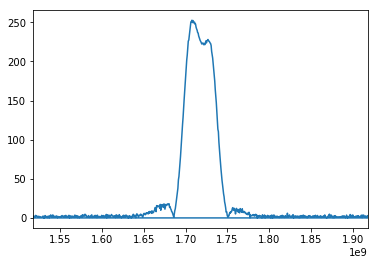

In [17]:
# Load in data 
import pandas as pd
basepath=r"/Volumes/Diamond/Projects/Networks/MWFidelity/Mean FFT LT4/"
fft_Meas= pd.read_csv(os.path.join(basepath,"after_cryo_fft.csv")).as_matrix()[:,0]
fft_Meas = ([complex(jj.replace('+-','-')) for jj in fft_Meas])
freq_Meas= (pd.read_csv(os.path.join(basepath,"after_cryo_freq.csv")).as_matrix()[:,0])
centr_freq=1.718064e9

plt.plot(freq_Meas,np.abs(fft_Meas))
plt.xlim([centr_freq - 200e6, centr_freq + 200e6]);

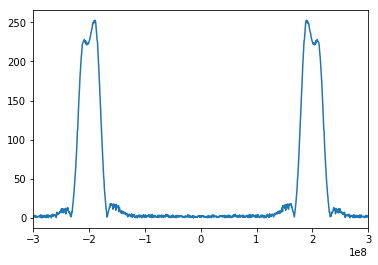

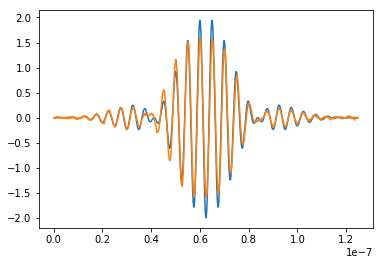

In [35]:
# Need to move pulse so that not at GHz, take to a reasonable value to compromise between capturing pulse shape and not having 
# too high a frequency

freq_offset = 200e6
freq_MeasS= freq_Meas -centr_freq+freq_offset
ind_zero = np.argmin(np.abs(freq_MeasS))

# Get phase of original signal
phase_term = np.angle(fft_Meas[np.argmin(np.abs(freq_MeasS -freq_offset))])
start_sig_time = 720.25e-9 # Needed to fix the phase of the pulse so that an X pulse
phase_shift = np.exp(1.0j*(phase_term+2*np.pi*start_sig_time/freq_offset))

# Calculate shifted FFT
shift_fft = np.array(fft_Meas[ind_zero:len(fft_Meas)/2])*phase_shift
shift_fft = np.append(shift_fft,np.flipud(np.conjugate(shift_fft[1:])))
shift_freq = freq_MeasS[ind_zero:len(fft_Meas)/2]
shift_freq = np.append(shift_freq,-np.flipud(shift_freq[1:]))
plt.plot(fftshift(shift_freq),fftshift(np.abs(shift_fft)))
plt.xlim([-3e8,3e8])
plt.show()

# Take to time domain
sig_Meas = (ifft(shift_fft,axis=0))
time_Meas = np.arange(0,shift_freq.shape[-1])/(((shift_freq.shape[-1]+1))*(freq_Meas[1]-freq_Meas[0]))
mintime = np.argmin(np.abs(time_Meas - start_sig_time))
maxtime = np.argmin(np.abs(time_Meas - 850e-9))
sig_Meas = np.real(sig_Meas[mintime:maxtime])
time_Meas = time_Meas[mintime:maxtime]-start_sig_time

# Interpolate
from scipy.interpolate import interp1d
pulseFnc = interp1d(time_Meas, sig_Meas, kind='linear')

def  gaussian_envelope_meas(t,duration):
    return 0.99*1.04*1.4*pulseFnc(t)

def  gaussian_envelope(t,duration):
    T_herm = 0.1667*duration
    return 2*np.cos(t*2*np.pi*200e6)*(1 - 0.957 * ((t- duration/2)/T_herm)**2) * np.exp(-((t - duration/2)/T_herm)**2)

plt.plot(np.arange(0.1e-9,125e-9,1e-10),gaussian_envelope(np.arange(0.1e-9,125e-9,1e-10),125e-9))
plt.plot(np.arange(0.1e-9,125e-9,1e-10),gaussian_envelope_meas(np.arange(0.1e-9,125e-9,1e-10),200e-9))

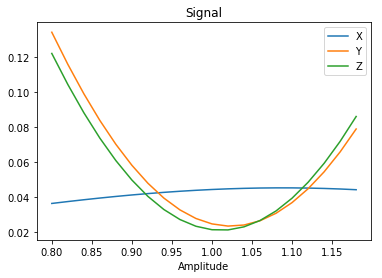

In [36]:
reload(nsc)
# Sweep amplitude to calibrate
NVsys = nsc.noisy_NV_system(mw_duration=125e-9,carbon_params = [],inc_nitrogen=False,pulse_shape='Hermite',norm_pulse=51850457.9335,compensate_mw_detuning = True,NV_detuning=200e6)
NVsys.gaussian_envelope = gaussian_envelope_meas
fids = nsc.mw_pulse_fid_scan_amp(NVsys)


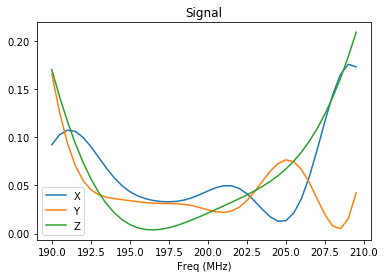

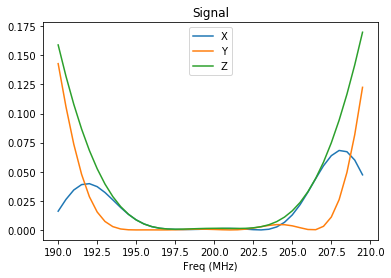

In [37]:
reload(nsc)

NVsys = nsc.noisy_NV_system(mw_duration=125e-9,carbon_params = [],inc_nitrogen=False,pulse_shape='Hermite',norm_pulse=51850457.9335,compensate_mw_detuning = True,mw_detuning=200e6)
NVsys.gaussian_envelope = gaussian_envelope_meas
fids = nsc.mw_pulse_fid_scan_freq(NVsys,freq_range =  np.arange(190e6,210.0e6,5e5))

NVsys = nsc.noisy_NV_system(mw_duration=125e-9,carbon_params = [],inc_nitrogen=False,pulse_shape='Hermite',norm_pulse=51850457.9335,compensate_mw_detuning = True,mw_detuning=200e6)
NVsys.gaussian_envelope = gaussian_envelope
fids = nsc.mw_pulse_fid_scan_freq(NVsys,freq_range =  np.arange(190e6,210.0e6,5e5))